## Initialization

In [70]:
import pandas as pd
import numpy as np
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import ydata_profiling as profiler

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

%matplotlib inline

In [2]:
root = pd.read_csv('mushrooms.csv')

About this file

Attribute Information: (classes: edible=e, poisonous=p)

cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s

cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s

cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y

bruises: bruises=t,no=f

odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s

gill-attachment: attached=a,descending=d,free=f,notched=n

gill-spacing: close=c,crowded=w,distant=d

gill-size: broad=b,narrow=n

gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y

stalk-shape: enlarging=e,tapering=t

stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?

stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s

stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s

stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y

stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y

veil-type: partial=p,universal=u

veil-color: brown=n,orange=o,white=w,yellow=y

ring-number: none=n,one=o,two=t

ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z

spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y

population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y

habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

## EDA

#### Creating a auto-generated profiling to search missing values and take an overview on data types.

In [3]:
prof = profiler.ProfileReport(root, title='Root data')
prof.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Creating plots for all values

In [4]:
root_encoded = root.copy()

In [5]:
root_encoders = [LabelEncoder() for _ in range(len(root.columns))]
for i in range(len(root.columns)):
    root_encoded.iloc[:, i] = root_encoders[i].fit_transform(root_encoded.iloc[:, i])

C:\Users\Ivan Demkov\AppData\Local\Temp\ipykernel_14516\814943733.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  root_encoded.iloc[:, i] = root_encoders[i].fit_transform(root_encoded.iloc[:, i])
C:\Users\Ivan Demkov\AppData\Local\Temp\ipykernel_14516\814943733.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  root_encoded.iloc[:, i] = root_encoders[i].fit_transform(root_encoded.iloc[:, i])
C:\Users\Ivan Demkov\AppData\Local\Temp\ipykernel_14516\814943733.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will at

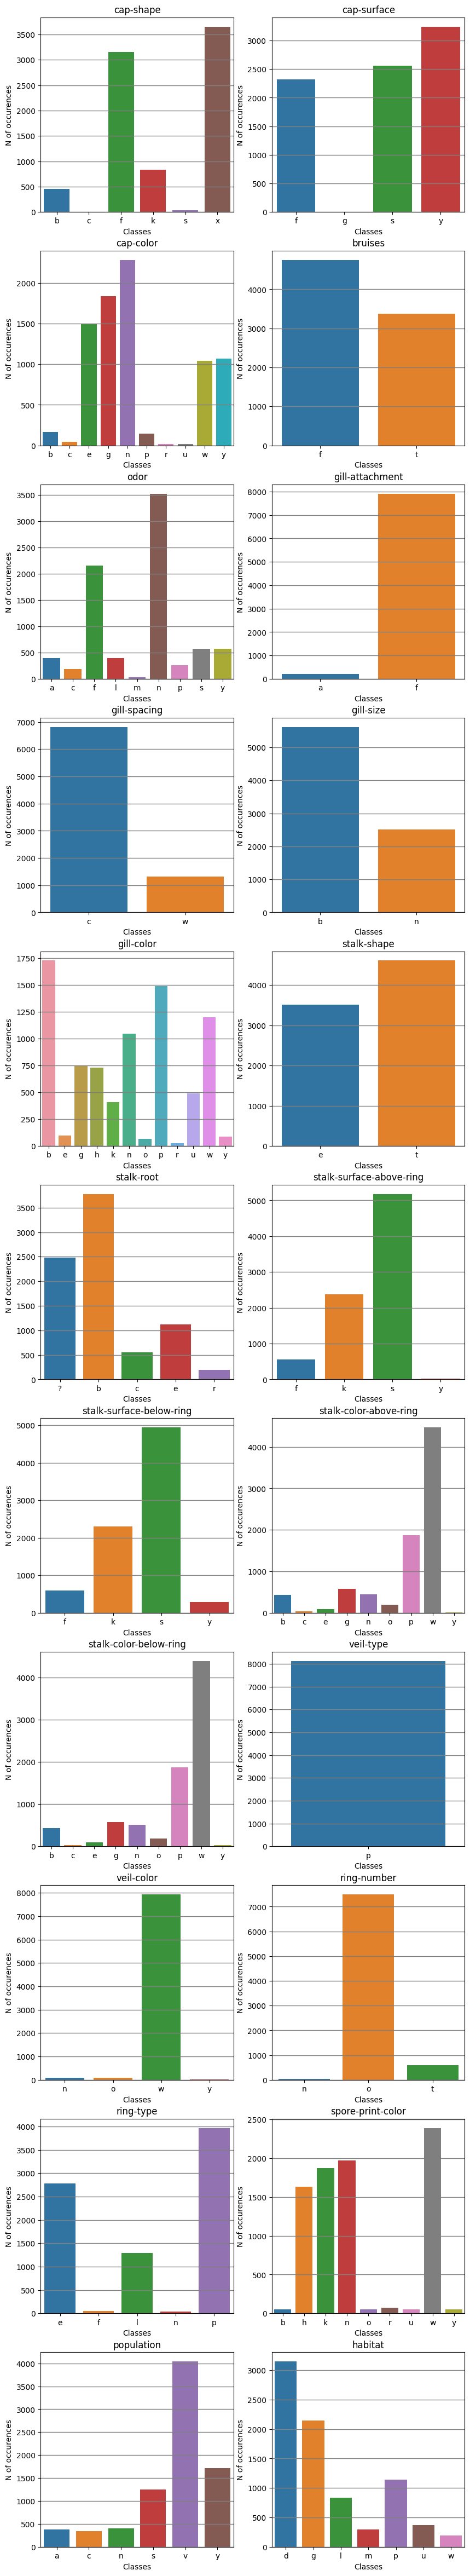

In [6]:
fig_features = plt.figure(figsize=(10, 60))
ax_features = fig_features.subplots(11, 2)
positions = [ax_features[i][j] for i in range(11) for j in range(2)]
for i in range(len(positions)):
    selected = pd.DataFrame(root.drop('class', axis=1).groupby(root.drop('class', axis=1).columns[i]).size()).transpose()
    sns.barplot(selected, ax=positions[i])
    positions[i].set_title(root.drop('class', axis=1).columns[i])
    positions[i].set_xlabel('Classes')
    positions[i].set_ylabel('N of occurences')
    positions[i].grid(color='gray', linewidth=1, axis='y')


#### Comparing correlations (encoded categories)

[Text(0.5, 1.0, 'Spearman')]

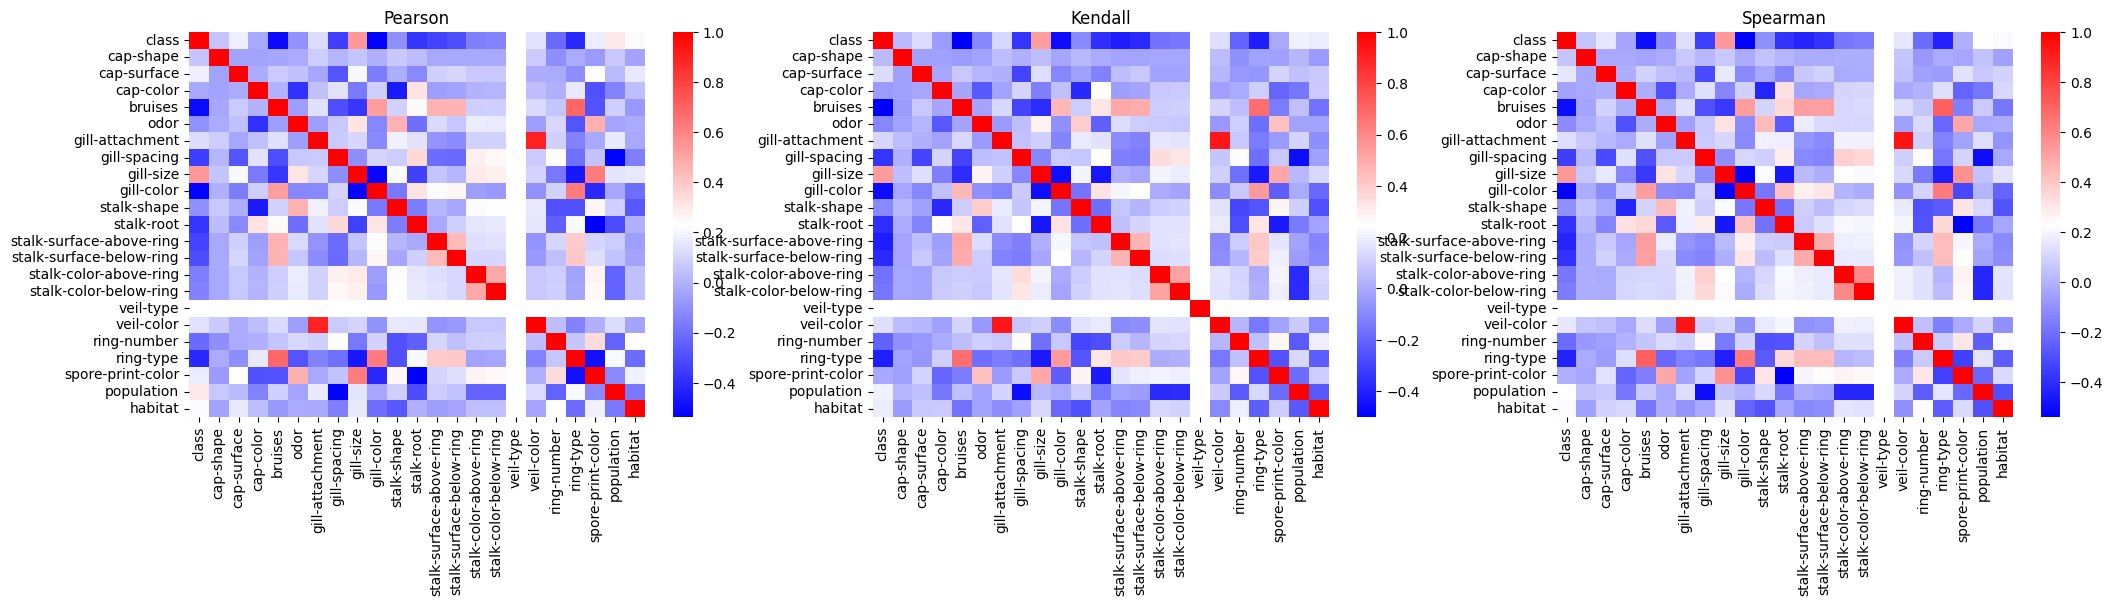

In [7]:
fig_corrs = plt.figure(figsize=(30, 5))
ax_corrs = fig_corrs.subplots(1, 3)
sns.heatmap(root_encoded.corr(method='pearson'), ax=ax_corrs[0], cmap='bwr').set(title='Pearson')
sns.heatmap(root_encoded.corr(method='kendall'), ax=ax_corrs[1], cmap='bwr').set(title='Kendall')
sns.heatmap(root_encoded.corr(method='spearman'), ax=ax_corrs[2], cmap='bwr').set(title='Spearman')

#### Starting preprocessing to seek features` relations

In [8]:
preprocessed_data = root.copy()

Getting unique values and planning the categorical classes expansion.

In [9]:
for col in preprocessed_data:
    print(col.ljust(25), sorted(preprocessed_data[col].unique()))

class                     ['e', 'p']
cap-shape                 ['b', 'c', 'f', 'k', 's', 'x']
cap-surface               ['f', 'g', 's', 'y']
cap-color                 ['b', 'c', 'e', 'g', 'n', 'p', 'r', 'u', 'w', 'y']
bruises                   ['f', 't']
odor                      ['a', 'c', 'f', 'l', 'm', 'n', 'p', 's', 'y']
gill-attachment           ['a', 'f']
gill-spacing              ['c', 'w']
gill-size                 ['b', 'n']
gill-color                ['b', 'e', 'g', 'h', 'k', 'n', 'o', 'p', 'r', 'u', 'w', 'y']
stalk-shape               ['e', 't']
stalk-root                ['?', 'b', 'c', 'e', 'r']
stalk-surface-above-ring  ['f', 'k', 's', 'y']
stalk-surface-below-ring  ['f', 'k', 's', 'y']
stalk-color-above-ring    ['b', 'c', 'e', 'g', 'n', 'o', 'p', 'w', 'y']
stalk-color-below-ring    ['b', 'c', 'e', 'g', 'n', 'o', 'p', 'w', 'y']
veil-type                 ['p']
veil-color                ['n', 'o', 'w', 'y']
ring-number               ['n', 'o', 't']
ring-type                 [

Removing homogeneous classes; they won`t have ane impact on analysis (for example veil-type)

In [10]:
homogeneous = []
for col in preprocessed_data:
    if len(preprocessed_data[col].unique()) < 2:
        homogeneous.append(col)
preprocessed_data = preprocessed_data.drop(homogeneous, axis=1)

Dividing features on one-columned and requiring multi-colon to see correlations

In [11]:
multiclass = []
for col in preprocessed_data:
    if len(preprocessed_data[col].unique()) > 2:
        multiclass.append(col)
multiclass

['cap-shape',
 'cap-surface',
 'cap-color',
 'odor',
 'gill-color',
 'stalk-root',
 'stalk-surface-above-ring',
 'stalk-surface-below-ring',
 'stalk-color-above-ring',
 'stalk-color-below-ring',
 'veil-color',
 'ring-number',
 'ring-type',
 'spore-print-color',
 'population',
 'habitat']

In [12]:
two_class = list(set(preprocessed_data.columns) - set(multiclass))
two_class

['gill-spacing',
 'class',
 'bruises',
 'gill-size',
 'gill-attachment',
 'stalk-shape']

Expanding such columns

In [13]:
for colname in multiclass:
    dummy = pd.get_dummies(preprocessed_data[colname])
    for col in list(dummy.columns):
        dummy = dummy.rename({col: f'{colname}-{col}'}, axis=1)
    preprocessed_data = pd.concat([preprocessed_data, dummy], axis=1, join='outer').drop(colname, axis=1)
preprocessed_data

,class,bruises,gill-attachment,gill-spacing,gill-size,stalk-shape,cap-shape-b,cap-shape-c,cap-shape-f,cap-shape-k,...,population-s,population-v,population-y,habitat-d,habitat-g,habitat-l,habitat-m,habitat-p,habitat-u,habitat-w
0,p,t,f,c,n,e,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,e,t,f,c,b,e,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,e,t,f,c,b,e,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,p,t,f,c,n,e,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,e,f,f,w,b,t,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,f,a,c,b,e,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
8120,e,f,a,c,b,e,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
8121,e,f,a,c,b,e,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
8122,p,f,f,c,n,t,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0


Encoding the rest of the features

In [14]:
encoders = [LabelEncoder() for _ in range(len(two_class))]
for i in range(len(two_class)):
    preprocessed_data[two_class[i]] = encoders[i].fit_transform(preprocessed_data.loc[:, two_class[i]])

In [21]:
preprocessed_data.dtypes.unique()

array([dtype('int32'), dtype('uint8')], dtype=object)

Now all features are numerical

#### Selecting significant features from extended correlation table (3 types of correlation)

In [15]:
significant_features = pd.Series()
corr_pearson = preprocessed_data.corr(method='pearson')
for col in corr_pearson:
    significant_features[col] = corr_pearson.loc[col].map(abs).sum()
significant_features = significant_features.sort_values(ascending=False).head(20)
significant_features = [elem for elem in corr_pearson.columns if elem in list(significant_features.index.values)]
corr_pearson = corr_pearson.loc[significant_features, significant_features]

C:\Users\Ivan Demkov\AppData\Local\Temp\ipykernel_14516\764213132.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  significant_features = pd.Series()


In [16]:
significant_features = pd.Series()
corr_kendall = preprocessed_data.corr(method='kendall')
for col in corr_kendall:
    significant_features[col] = corr_kendall.loc[col].map(abs).sum()
significant_features = significant_features.sort_values(ascending=False).head(20)
significant_features = [elem for elem in corr_kendall.columns if elem in list(significant_features.index.values)]
corr_kendall = corr_kendall.loc[significant_features, significant_features]

C:\Users\Ivan Demkov\AppData\Local\Temp\ipykernel_14516\1948149242.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  significant_features = pd.Series()


In [17]:
significant_features = pd.Series()
corr_spearman = preprocessed_data.corr(method='spearman')
for col in corr_spearman:
    significant_features[col] = corr_spearman.loc[col].map(abs).sum()
significant_features = significant_features.sort_values(ascending=False).head(20)
significant_features = [elem for elem in corr_spearman.columns if elem in list(significant_features.index.values)]
corr_spearman = corr_spearman.loc[significant_features, significant_features]

C:\Users\Ivan Demkov\AppData\Local\Temp\ipykernel_14516\3031186000.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  significant_features = pd.Series()


##### Creating heatmaps

[Text(0.5, 1.0, 'Spearman')]

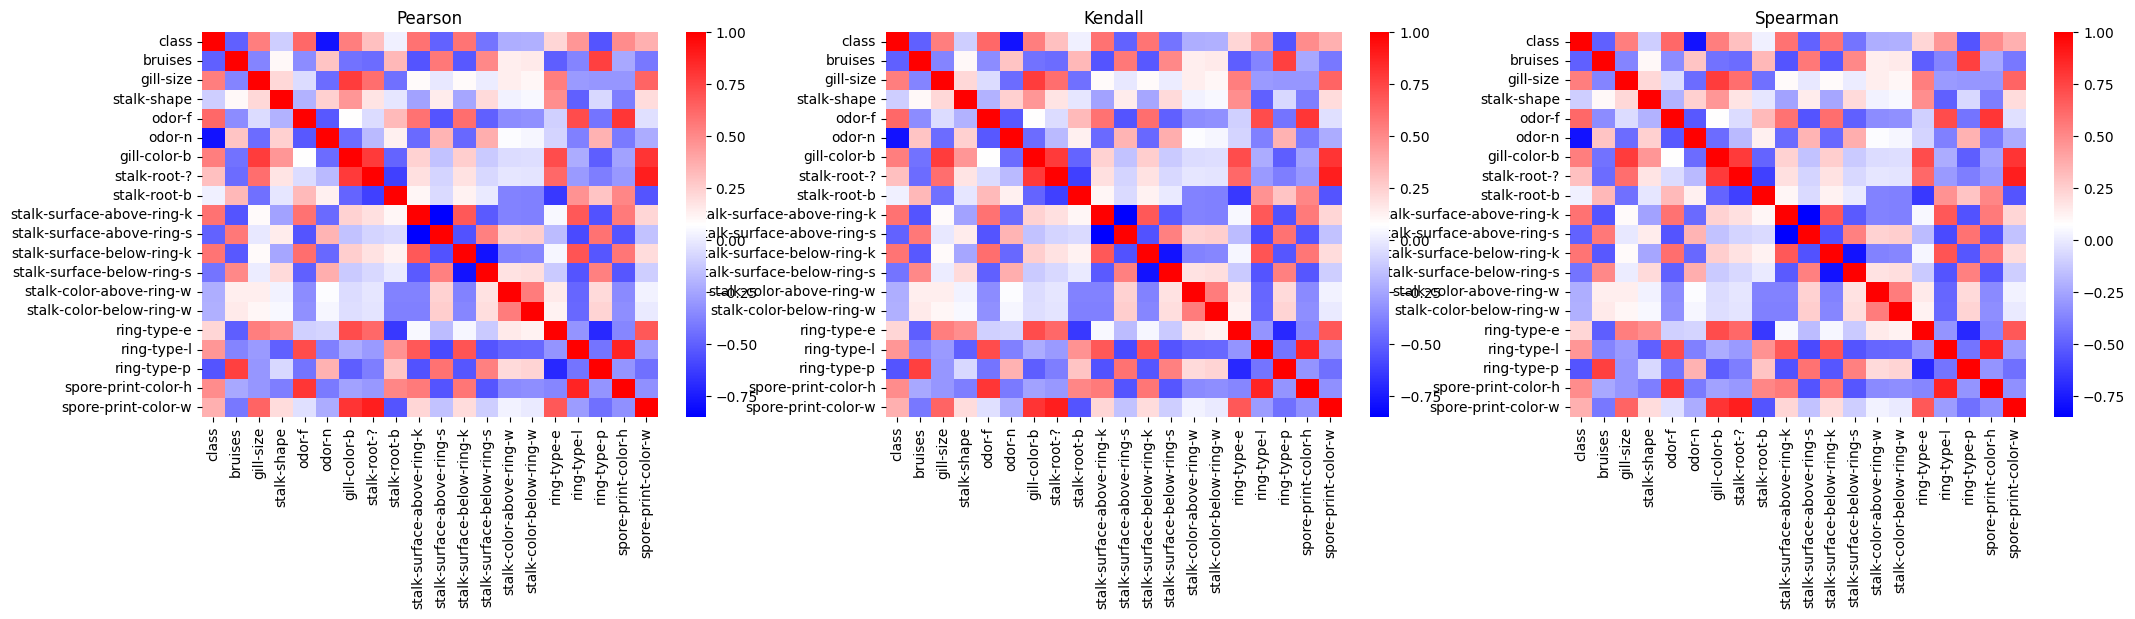

In [18]:
fig_corrs = plt.figure(figsize=(25, 5))
ax_corrs = fig_corrs.subplots(1, 3)
sns.heatmap(corr_pearson, ax=ax_corrs[0], cmap='bwr').set(title='Pearson')
sns.heatmap(corr_kendall, ax=ax_corrs[1], cmap='bwr').set(title='Kendall')
sns.heatmap(corr_spearman, ax=ax_corrs[2], cmap='bwr').set(title='Spearman')

#### Finding correlations with edibility

Getting correlation with edibility

In [22]:
corr_matrix = preprocessed_data.corr().loc[:, 'class'].drop('class', axis=0)

Building table of frequent correlations` strengths

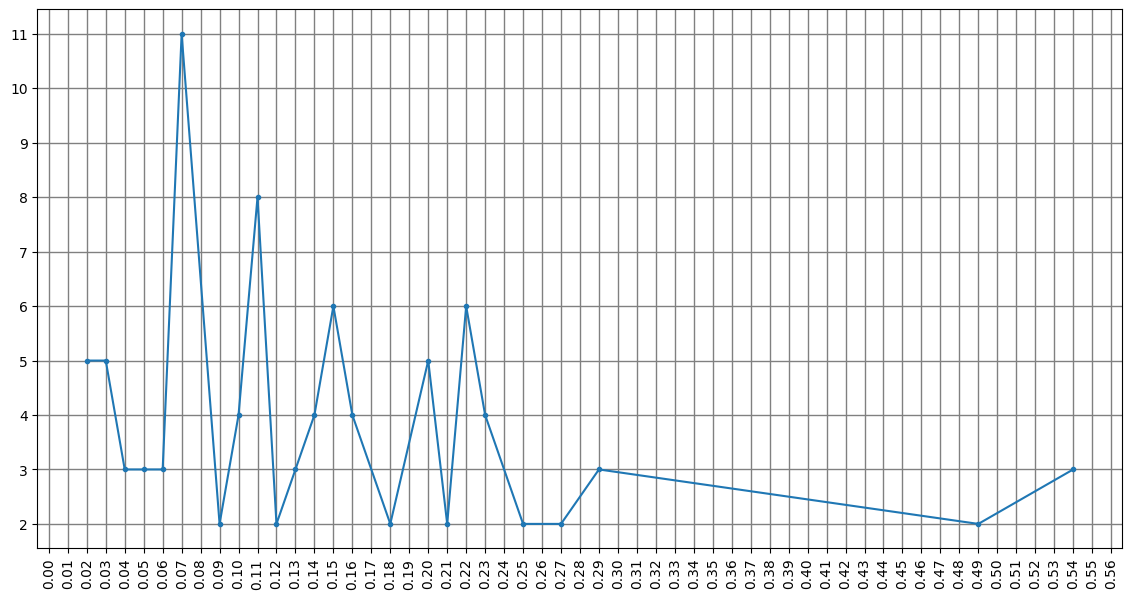

In [23]:
plotting = corr_matrix.map(abs).round(2).value_counts().sort_index()
fig = plt.figure(figsize=(14, 7))
ax_correlation_quantities = fig.subplots()

plt.xticks(rotation=90)
ax_correlation_quantities.set_yticks(np.arange(0, 12, 1))
ax_correlation_quantities.set_xticks(np.arange(-1, 1, 0.01))
ax_correlation_quantities.grid(color='gray', linewidth=1)
ax_correlation_quantities.plot(plotting.loc[plotting > 1], marker='.')

Significant correlations are located after 0.48, so optimal precision is 0.48

Full correlation table with feature names and highlighting

In [24]:
corr_precision = 0.48
def stylemap_corr(value):
    if value > corr_precision:
        style = 'background-color: palegreen'
    elif value < 0 and abs(value) >= corr_precision:
        style = 'background-color: pink'
    else:
        style = 'background-color: gray'
    return style
pd.DataFrame(corr_matrix).style.applymap(stylemap_corr).applymap(lambda x: 'color: black')

,class
bruises,-0.501530
gill-attachment,0.129200
gill-spacing,-0.348387
gill-size,0.540024
stalk-shape,-0.102019
cap-shape-b,-0.182567
cap-shape-c,0.023007
cap-shape-f,0.018526
cap-shape-k,0.163565
cap-shape-s,-0.060664


Auto-generated plot with chosen features

In [25]:
entry = corr_matrix.copy()
entry = entry.loc[abs(entry) > corr_precision]

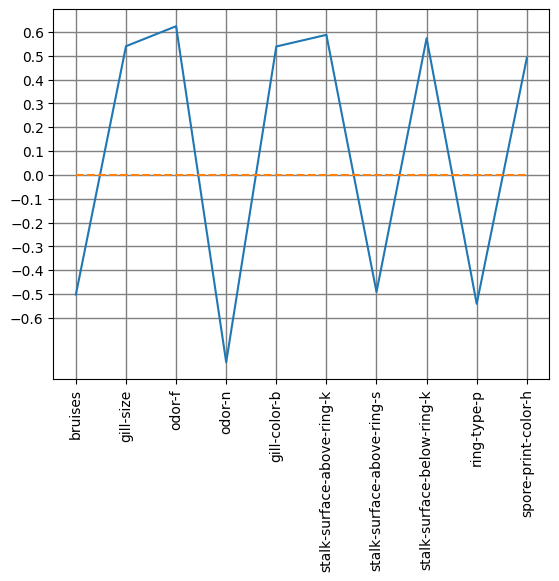

In [26]:
fig = plt.figure()
ax_corr = fig.subplots()
plt.xticks(rotation=90)
ax_corr.set_yticks(np.arange(-0.6,1,0.1))
ax_corr.grid(color='gray', linewidth=1)
ax_corr.plot(entry)
ax_corr.plot([0 for _ in range(entry.count())], linestyle='--')

#### Making hypothesis

Hypothesis:

1) gill-size = narrow, odor = foul, gill-color = buff, stalk-surface-above-ring = silky, stalk-surface-below-ring = silky, spore-print-color = chocolate -> more likely to be poisonous

2) bruises = true, odor = none, stalk-surface-above-ring = smooth, ring-type = pendant -> more likely to be edible


## Modelling

#### Preparing data for models

In [27]:
modelling_dataset = root.copy()

Getting chosen features from analysis

In [28]:
key_features = [elem for elem in corr_matrix.map(abs).loc[abs(corr_matrix) > corr_precision].axes[0]]
key_features.insert(0, 'class')
print(key_features)
selected_features = [elem for elem in modelling_dataset.columns if elem in set(re.findall("\\b{0}".format(elem), ' '.join(key_features)))]

['class', 'bruises', 'gill-size', 'odor-f', 'odor-n', 'gill-color-b', 'stalk-surface-above-ring-k', 'stalk-surface-above-ring-s', 'stalk-surface-below-ring-k', 'ring-type-p', 'spore-print-color-h']


In [61]:
base_data = modelling_dataset.loc[:, selected_features]

Encoding it with number classes

In [62]:
encoders = [LabelEncoder() for _ in range(base_data.shape[1])]
for i in range(base_data.shape[1]):
    base_data[base_data.columns[i]] = encoders[i].fit_transform(base_data[base_data.columns[i]])

Splitting data on train and test

In [32]:
X, y = base_data.drop('class', axis=1), base_data.loc[:, 'class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

Checking data in columns

In [69]:
for col in X:
    print(sorted(X[col].unique()))

[0, 1]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4, 5, 6, 7, 8]


#### Some functions to test classifiers

In [34]:
def get_classifier_importances(clf_):
    feature_importance = pd.DataFrame()
    feature_importance['importance'] = pd.Series(clf_.feature_importances_, clf_.feature_names_in_)
    feature_importance['above_average'] = (feature_importance['importance'] - feature_importance['importance'].mean())
    display(feature_importance.sort_values('above_average', ascending=False))

In [35]:
def get_scores(clf_, X_, y_):
    print('Cross-val: ', cross_val_score(clf_, X_, y_, cv=5).mean())
    prediction = clf_.predict(X_)
    print('Accuracy: ', accuracy_score(y_, prediction))
    print('Precision: ', precision_score(y_, prediction))
    print('Recall: ', recall_score(y_, prediction))
    sns.heatmap(confusion_matrix(y_, prediction), annot=True)

#### RandomForestClassifier

In [36]:
clf_forest = RandomForestClassifier(n_jobs=-1)
params = {
    'n_estimators' : range(10, 25),
    'max_depth': range(1, 11),
    # 'min_samples_split': range(1, 6),
    # 'min_samples_leaf': range(1, 6)
}
search_forest = GridSearchCV(clf_forest, params, verbose=2)

In [37]:
search_forest.fit(X_train, y_train)
clf_forest = search_forest.best_estimator_

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV] END .......................max_depth=1, n_estimators=10; total time=   3.5s
[CV] END .......................max_depth=1, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=11; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=11; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=11; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=11; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=11; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=12; total time=   0.0s
[CV] END .......................max_depth=1, n

In [38]:
get_classifier_importances(clf_forest)

,importance,above_average
gill-color,0.250588,0.125588
odor,0.241649,0.116649
spore-print-color,0.160164,0.035164
gill-size,0.107762,-0.017238
stalk-surface-above-ring,0.081008,-0.043992
stalk-surface-below-ring,0.056579,-0.068421
bruises,0.056372,-0.068628
ring-type,0.045878,-0.079122


Cross-val:  0.9969230769230769
Accuracy:  1.0
Precision:  1.0
Recall:  1.0


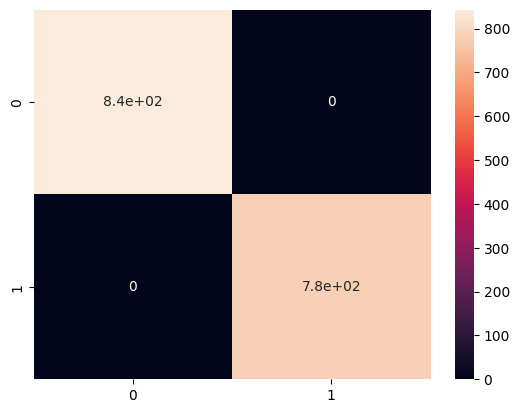

In [39]:
get_scores(clf_forest, X_test, y_test)

#### NaiveBayes

In [40]:
clf_gnb = GaussianNB()
clf_gnb.fit(X_train, y_train)

GaussianNB()

Cross-val:  0.7963076923076923
Accuracy:  0.8313846153846154
Precision:  0.7926267281105991
Recall:  0.8797953964194374


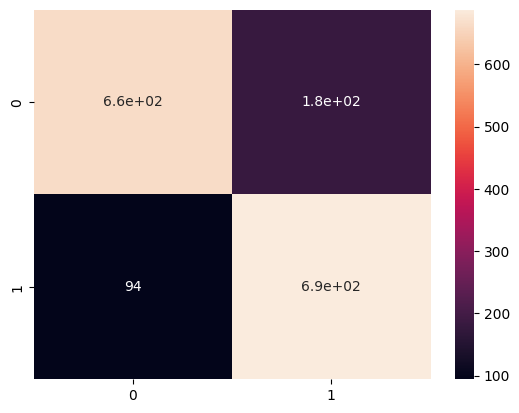

In [41]:
get_scores(clf_gnb, X_test, y_test)

#### Logistic Regression

In [42]:
clf_lgr = LogisticRegression()

In [43]:
clf_lgr.fit(X_train, y_train)

LogisticRegression()

Cross-val:  0.8775384615384615
Accuracy:  0.9009230769230769
Precision:  0.8692033293697978
Recall:  0.9347826086956522


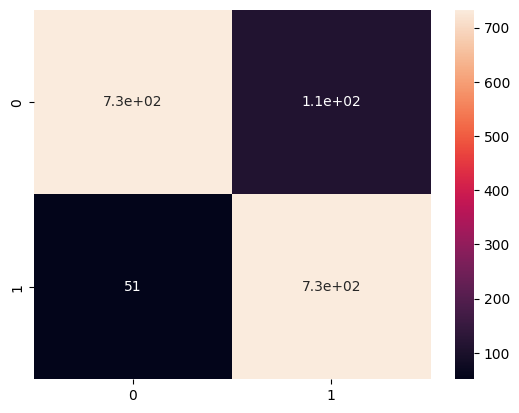

In [44]:
get_scores(clf_lgr, X_test, y_test)

In [84]:
clf_xgb = xgb.XGBClassifier(learning_rate=0.75, max_depth=3, random_state=1, gamma=0, eval_metric='error')
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Cross-val:  0.9993846153846153
Accuracy:  1.0
Precision:  1.0
Recall:  1.0


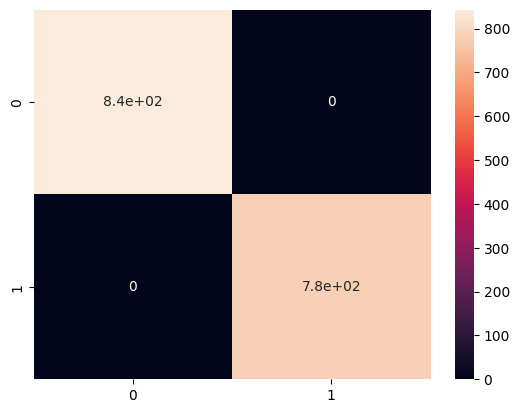

In [86]:
get_scores(clf_xgb, X_test, y_test)

In [89]:
get_classifier_importances(clf_xgb)

,importance,above_average
gill-color,0.488192,0.363192
spore-print-color,0.178207,0.053207
gill-size,0.178147,0.053147
odor,0.076960,-0.048040
stalk-surface-below-ring,0.042378,-0.082622
bruises,0.032667,-0.092333
stalk-surface-above-ring,0.002362,-0.122638
ring-type,0.001087,-0.123913
